<a href="https://colab.research.google.com/github/etemadism/Courses/blob/main/ArrayExpress_RNA_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Google Colab Tutorial: RNA-seq Analysis with edgeR, limma, and pheatmap**

Ali Etemadi


### Introduction

In this session of *Computation and Systems Biology*, we will explore the differential gene expression analysis of RNA-seq data using various computational tools. Our focus is on understanding the transcriptional landscape of young and senescent human umbilical vein endothelial cells (HUVECs) under normal and high glucose conditions. By leveraging high-throughput RNA-sequencing (RNA-seq) data, we aim to analyze how cellular senescence and high glucose (HG) levels influence gene expression patterns, which are crucial for understanding endothelial dysfunction in diseases like Type 2 Diabetes (T2D) and cardiovascular disorders.

### About the Dataset

The dataset we will be using consists of RNA-seq data from HUVECs cultured under different conditions:
- Young HUVECs under normal glucose conditions
- Young HUVECs under high glucose conditions
- Senescent HUVECs under normal glucose conditions
- Senescent HUVECs under high glucose conditions

This dataset consists of 12 samples, each representing a specific condition. The goal is to identify differentially expressed genes (DEGs) between these conditions using statistical tools from the R environment, including `limma` and `edgeR`.

### How to Access the Data

The dataset is publicly available under the accession number **[E-MTAB-13959](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-13959?query=%22type%202%20diabetes%20mellitus%22%20)**. It includes the following files:
- **gene_count_matrix.txt**: Contains the processed gene count data for all 12 samples.
- **E-MTAB-13959.idf.txt**: Provides metadata and experimental design information.
- **E-MTAB-13959.sdrf.txt**: Describes the relationship between the samples and data.

You can download the files from the repository and load them into your computational environment for analysis. We will perform normalization, differential expression analysis, and visualize the results using tools such as edgeR, limma, and pheatmap.

Through this hands-on tutorial, you will gain practical experience in analyzing RNA-seq data and interpreting biologically relevant results.



**Important Note**

Before starting the analysis, make sure to change the runtime type to **R** in your Google Colab environment. You can do this by clicking on **Runtime** in the menu, selecting **Change runtime type**, and then choosing **R** from the dropdown menu.


**Step 1**: Set up the environment
Before starting, you need to install the necessary packages. Google Colab runs in a clean environment, so each session requires package installation.

**BiocManager**: This package manager is essential for installing edgeR and other Bioconductor packages, commonly used for bioinformatics and genomic data analysis.

In [23]:
# Install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Install edgeR using BiocManager
BiocManager::install("edgeR")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”


**Step 2: Load the Required Libraries**

Once installed, load the libraries into the environment to access their functions.

**edgeR**: Used for handling RNA-seq data and performing differential expression analysis.

**pheatmap**: Useful for creating heatmaps of gene expression data.

In [24]:
# Load the necessary edgeR library
library(edgeR)

# Create a DGEList object and calculate normalization factors
dge <- DGEList(counts=counts)
dge <- calcNormFactors(dge)


In [25]:
# Install pheatmap
install.packages("pheatmap")

# Load the package
library(pheatmap)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Step 3: Load and Prepare the Data**

The input data consists of a count matrix (a file with gene expression counts) and sample information that distinguishes control from treatment groups.

In [26]:
# Load count matrix
counts <- read.delim("gene_count_matrix.txt", row.names = 1)

# Create a sample_info data frame (ensure this reflects your actual experiment design)
sample_info <- data.frame(
  sample = colnames(counts),
  condition = factor(c("control", "control", "control", "treatment", "treatment", "treatment"))  # Use factor
)

# Check sample_info
print(sample_info)

             sample condition
1       s1_NG_1Y_P6   control
2       s2_NG_2Y_P6   control
3       s3_NG_3Y_P4   control
4       s4_HG_1Y_P6 treatment
5       s5_HG_2Y_P6 treatment
6       s6_HG_3Y_P4 treatment
7   s7_NG1_1SEN_P16   control
8   s8_NG3_2SEN_P16   control
9   s9_NG2_3SEN_P18   control
10 s10_HG1_1SEN_P16 treatment
11 s11_HG3_2SEN_P16 treatment
12 s12_HG2_3SEN_P18 treatment


*counts*: A matrix where rows represent genes and columns represent samples. Each entry is the expression count for a gene in a sample.

*sample_info*: Metadata that defines the experimental groups (control and treatment). The condition column specifies the group of each sample.

**Step 4: Normalize the Data**

Normalization adjusts for variations in library size (total read counts per sample), ensuring fair comparisons between genes and samples.

In [27]:
# Load edgeR and normalize the data
library(edgeR)
dge <- DGEList(counts=counts)
dge <- calcNormFactors(dge)  # Normalize based on library size

*Normalization*: The calcNormFactors function scales the counts to account for library size differences between samples.

**Step 5: Perform Differential Expression Analysis**

Next, use the limma package to fit a linear model to the normalized data and identify differentially expressed genes.

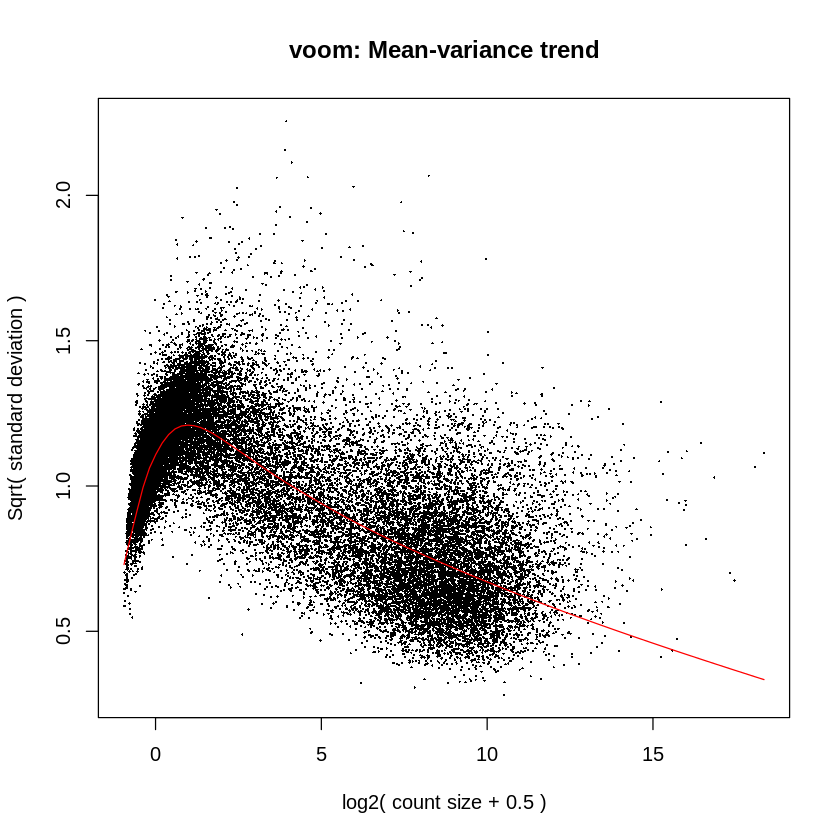

In [28]:
# Perform differential expression analysis using limma and edgeR
library(limma)
design <- model.matrix(~condition, data=sample_info)

# Voom transformation (mean-variance plot is included)
v <- voom(dge, design, plot=TRUE)

# Fit the linear model using limma
fit <- lmFit(v, design)

# Apply empirical Bayes moderation
fit <- eBayes(fit)

*voom*: Transforms the count data to log-counts per million (log-CPM) and estimates the mean-variance trend, improving statistical modeling.

*lmFit & eBayes*: Fit the linear model and apply empirical Bayes moderation to shrink variance estimates, leading to more stable results.

**Step 6: Get the Top Differentially Expressed Genes**

Now extract the top 10 differentially expressed genes based on their P-values.

In [29]:
# Extract the top 10 differentially expressed genes based on P-value
topGenes <- topTable(fit, number=10, sort.by="P")
print(topGenes)

Removing intercept from test coefficients



                       logFC    AveExpr         t      P.Value adj.P.Val
ENSG00000176402.6  -2.084940 -3.1767562 -4.917602 0.0001550161 0.9728359
ENSG00000279118.1  -2.240248 -3.2786222 -4.715623 0.0002338562 0.9728359
ENSG00000284844.2  -2.071488 -3.6587287 -4.356262 0.0004908365 0.9728359
ENSG00000203279.6   2.582612 -2.2898024  4.334966 0.0005130617 0.9728359
ENSG00000256514.1  -4.759852  0.1660601 -4.282800 0.0005719309 0.9728359
ENSG00000270117.2   1.864215 -3.5125685  4.266042 0.0005922657 0.9728359
ENSG00000267426.5   2.621273 -1.6986987  4.090158 0.0008555723 0.9728359
ENSG00000283453.2   1.940758 -3.1394680  3.923058 0.0012154099 0.9728359
ENSG00000100121.14  1.979409 -3.6725165  3.885685 0.0013149108 0.9728359
ENSG00000230882.1  -2.409434 -3.1319237 -3.853076 0.0014084169 0.9728359
                           B
ENSG00000176402.6  -4.440024
ENSG00000279118.1  -4.431105
ENSG00000284844.2  -4.442109
ENSG00000203279.6  -4.459956
ENSG00000256514.1  -4.454653
ENSG00000270117.2  -4.4

**topTable**: Retrieves the genes with the most significant differential expression, including log-fold changes and adjusted P-values.

**Step 7: Visualize the Results**

**Volcano Plot**

A volcano plot shows log-fold changes on the x-axis and the significance (−log10 of P-values) on the y-axis, highlighting the most significantly differentially expressed genes.



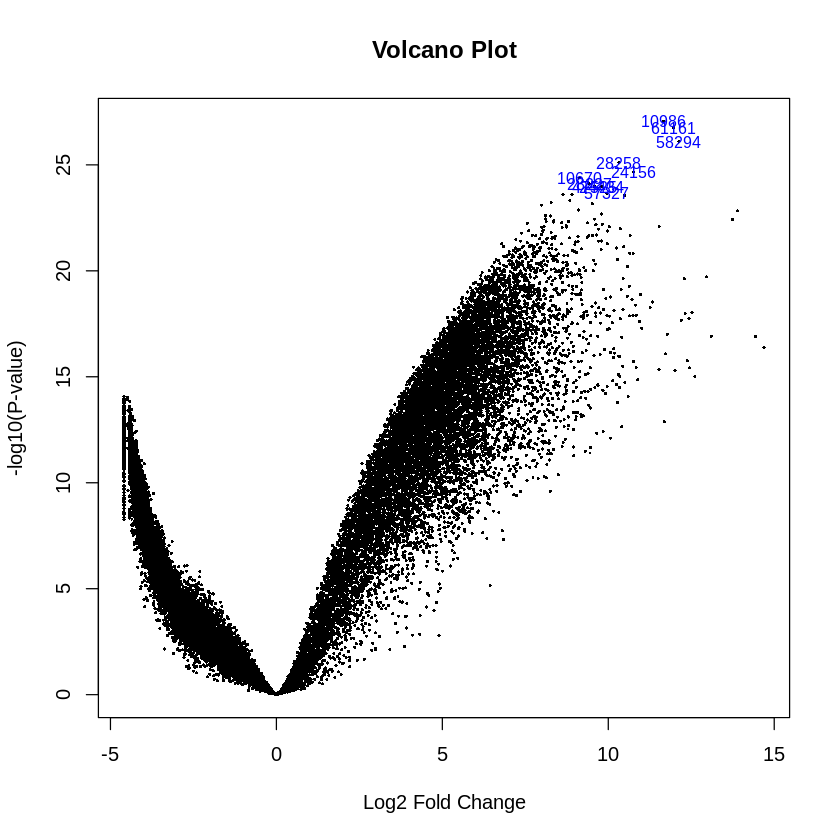

In [30]:
# 2. Volcano Plot
volcanoplot(fit, main="Volcano Plot", highlight=10)

**Heatmap of Top 10 Differentially Expressed Genes**

A heatmap visualizes expression levels of the top genes across the samples, showing patterns of gene regulation.

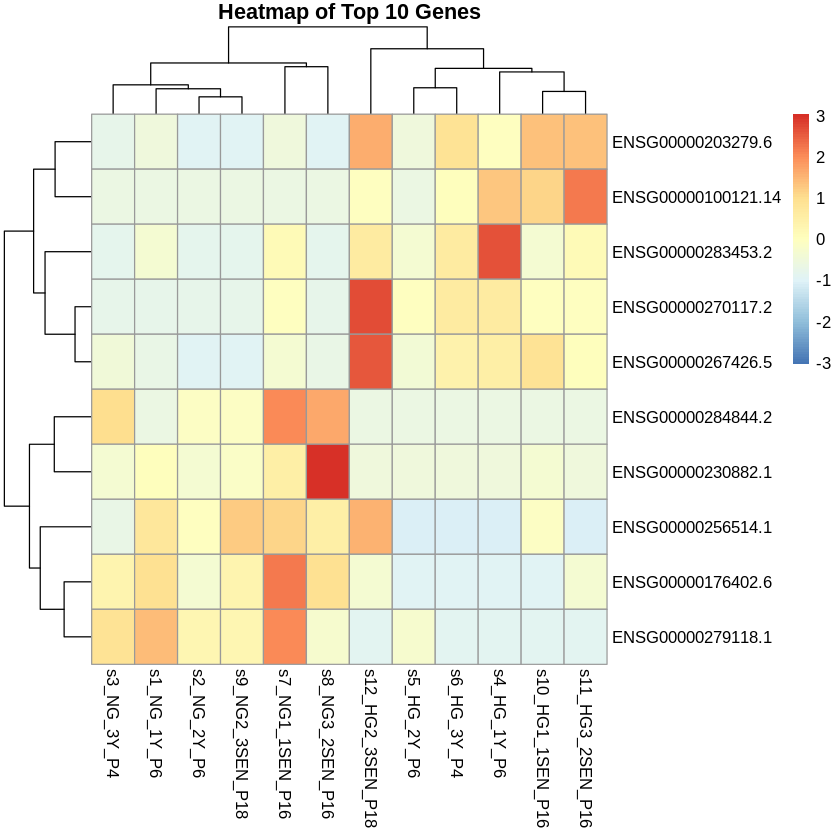

In [31]:
# 3. Heatmap of Top 10 Differentially Expressed Genes
library(pheatmap)

# Select top 10 differentially expressed genes (by row names)
top_genes <- rownames(topGenes)

# Subset count matrix for top genes
top_counts <- counts[top_genes,]

# Create heatmap
pheatmap(top_counts, scale="row", clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean", main="Heatmap of Top 10 Genes")


**pheatmap**: Automatically clusters genes and samples by their expression patterns, and the scale="row" argument standardizes each gene's expression.

**Step 8: Save the Results**

Finally, save the differential expression results for further analysis.

In [32]:
write.table(topTable(fit), "differential_expression_results.txt", sep="\t", quote=FALSE)


Removing intercept from test coefficients

